In [54]:
!pip install dotenv 
!pip install duckdb

In [55]:
# Data treatment

import numpy as np # linear algebra
import polars as pl # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import duckdb
from sklearn.preprocessing import OrdinalEncoder

# Data visualization

import seaborn as sns


# OS and Dotenv

#from dotenv import load_dotenv
import os
#load_dotenv()  

# Deep Learning

import torch                  
import torch.nn as nn          
import torch.nn.functional as F  
import torch.optim as optim  
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset, TensorDataset

# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths

dataset_path = "/kaggle/input/amazon-books-reviews"
dataset_ratings = os.path.join(dataset_path, "Books_rating.csv")
dataset_books = os.path.join(dataset_path, "books_data.csv")

%env CUDA_LAUNCH_BLOCKING=1


env: CUDA_LAUNCH_BLOCKING=1


In [56]:
duckdb_file = '/kaggle/working/proto.duckdb'

if duckdb_file == None:
    
    books_data = pl.read_csv(dataset_books)
    ratings = pl.read_csv(dataset_ratings)
    
    con = duckdb.connect("proto.duckdb")
    
    con.execute(f"""
    CREATE OR REPLACE TABLE books AS
    SELECT * FROM read_csv_auto('{dataset_books}');
    """)
    
    con.execute(f"""
    CREATE OR REPLACE TABLE ratings AS
    SELECT * FROM read_csv_auto('{dataset_ratings}');
    """)
else:
    print('The file already exists')

    con = duckdb.connect("proto.duckdb")

    print('Connected.')



The file already exists
Connected.


In [57]:
query = """SELECT 
    b.Title, 
    b.authors, 
    b.categories, 
    r.Id, 
    r.User_id, 
    r."review/score",
    b.ratingsCount
FROM books b
JOIN ratings r ON b.Title = r.Title;"""

df_merged = con.execute(query).fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

## Pre-processing

### EDA


In [58]:
df_merged

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Title,authors,categories,Id,User_id,review/score,ratingsCount
0,Never Cry Wolf,['Farley Mowat'],['Animal behavior'],0316586390,A3D5EO8SCPTX9W,5.0,34.0
1,Never Cry Wolf,['Farley Mowat'],['Animal behavior'],0316586390,A24N8O90K345KV,5.0,34.0
2,Never Cry Wolf,['Farley Mowat'],['Animal behavior'],0316586390,A2CF0A2HR4OS22,5.0,34.0
3,Never Cry Wolf,['Farley Mowat'],['Animal behavior'],0316586390,None,5.0,34.0
4,Never Cry Wolf,['Farley Mowat'],['Animal behavior'],0316586390,A1VXA74UYHCT9E,1.0,34.0
...,...,...,...,...,...,...,...
2999787,Adams V. Texas,"['Randall Dale Adams', 'William Hoffer', 'Mari...",['Law'],1559271779,A7OTNBHKRG1PV,5.0,NaN
2999788,Adams V. Texas,"['Randall Dale Adams', 'William Hoffer', 'Mari...",['Law'],1559271779,A568XT9TD0PWH,1.0,NaN
2999789,Secret Missions of the Civil War,['Philip Van Doren Stern'],['History'],B000NSQU3K,None,4.0,2.0
2999790,Secret Missions of the Civil War,['Philip Van Doren Stern'],['History'],B000NSQU3K,A3Q04EJ3QO6ABX,4.0,2.0


I'm going to use only the ratings, since our project will use model-based collaborative filtering.

In [59]:
len(df_merged['Title'].unique())

212403

In [60]:
filtering_ratings_per_user = df_merged.groupby("User_id")["review/score"].count().reset_index(name="total_reviews")

In [61]:
filtering_ratings_per_user['total_reviews'].describe()

count    1.008961e+06
mean     2.416365e+00
std      1.213252e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.795000e+03
Name: total_reviews, dtype: float64

In [62]:
reviews_median = filtering_ratings_per_user['total_reviews'].median()

Since our dataset is asymmetric, I'm using median instead of mean

In [63]:
n_items = len(df_merged['Title'].unique())
n_users = len(df_merged['User_id'].unique())

print(f"The number of books is {n_items}")
print("---------------------------")
print(f"The number of users is {n_users}")
print("---------------------------")
print(f'The number of ratings per user is {reviews_median} ')
print("---------------------------")
print(f'Full rating matrix will have: {n_users*n_items} elements')
print("---------------------------")
print(f'Number of rating: {len(df_merged)}')
print("---------------------------")
print(f'Therefore: {(len(df_merged) / (n_users * n_items)) * 100}% of matrix is filled')

The number of books is 212403
---------------------------
The number of users is 1008962
---------------------------
The number of ratings per user is 1.0 
---------------------------
Full rating matrix will have: 214306555686 elements
---------------------------
Number of rating: 2999792
---------------------------
Therefore: 0.0013997667921998931% of matrix is filled


<Axes: xlabel='review/score', ylabel='count'>

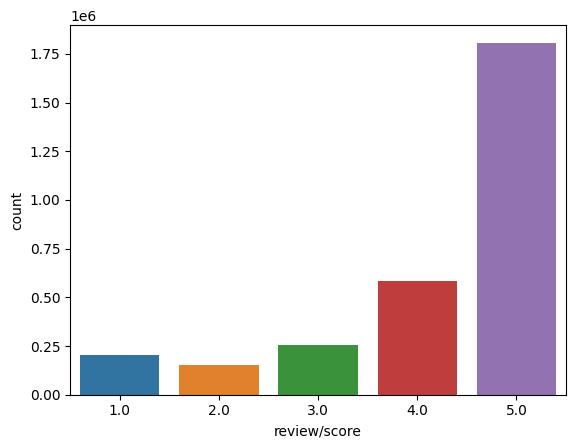

In [64]:
sns.countplot(df_merged, x="review/score")

### Processing

In [65]:
df_merged['categories'] = df_merged['categories'].fillna('No Category')

df_merged['ratingsCount'] = df_merged['ratingsCount'].fillna(0)

In [66]:
df_merged.describe()

,review/score,ratingsCount
count,2.999792e+06,2.999792e+06
mean,4.215263e+00,1.486760e+02
std,1.203066e+00,5.986146e+02
min,1.000000e+00,0.000000e+00
25%,4.000000e+00,0.000000e+00
50%,5.000000e+00,1.000000e+00
75%,5.000000e+00,1.300000e+01
max,5.000000e+00,4.895000e+03


In [67]:
df_merged.isna().sum()

Title                0
authors         390634
categories           0
Id                   0
User_id         561774
review/score         0
ratingsCount         0
dtype: int64

As expected, we have a lot of NaN values in User_id.

I can't use these IDs in the way they are right now. Im going to treatment them using ordinalencoder, since the matrix factorization presuppose continuous IDs

In [68]:
# 0. Preprocessing the strings

df_merged['categories'] = df_merged['categories'].str.replace('[', '', regex=False).str.replace(']', '', regex=False)
df_merged['authors'] = df_merged['authors'].str.replace('[', '', regex=False).str.replace(']', '', regex=False)

# 1. Ordinal Encoder

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoded = encoder.fit_transform(df_merged[['User_id', 'Id', 'categories', 'authors']].to_numpy())

df_encoded = df_merged.copy()
df_encoded['User_id'] = encoded[:, 0].astype(int)
df_encoded['Id'] = encoded[:, 1].astype(int)
df_encoded['categories'] = encoded[:, 2].astype(int)
df_encoded['authors'] = encoded[:, 3].astype(int)


df_encoded = df_encoded[(df_encoded['User_id'] != -1) & (df_encoded['Id'] != -1)]



In [69]:
import joblib

joblib.dump(encoder, 'ordinal_encoder.joblib')

['ordinal_encoder.joblib']

I'm going to remove all users who only interacted 1 time, to see if improves our metrics.

In [70]:
user_counts = df_encoded['User_id'].value_counts()
df_filtered = df_encoded[df_encoded['User_id'].isin(user_counts[user_counts >= 2].index)]


In [71]:
df_filtered

,Title,authors,categories,Id,User_id,review/score,ratingsCount
0,Never Cry Wolf,37515,813,16719,630217,5.0,34.0
1,Never Cry Wolf,37515,813,16719,301311,5.0,34.0
2,Never Cry Wolf,37515,813,16719,358899,5.0,34.0
3,Never Cry Wolf,37515,813,16719,1008961,5.0,34.0
4,Never Cry Wolf,37515,813,16719,236768,1.0,34.0
...,...,...,...,...,...,...,...
2999786,Adams V. Texas,98438,7319,108783,1008961,4.0,0.0
2999787,Adams V. Texas,98438,7319,108783,799252,5.0,0.0
2999789,Secret Missions of the Civil War,96360,6406,210869,1008961,4.0,2.0
2999790,Secret Missions of the Civil War,96360,6406,210869,725164,4.0,2.0


I didnt drop the nulls before, but i'm treating with the line df_encoded = df_encoded[(df_encoded['User_id'] != -1) & (df_encoded['Id'] != -1)]


To avoid data leak, because we have a lot of users, im going to divide the dataset per user, not only per percentage

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Stratifing
user_score = df_filtered.groupby("User_id")["review/score"].median().reset_index()

train_users, temp_users = train_test_split(
    user_score,
    test_size=0.4,
    stratify=user_score["review/score"],
    random_state=42
)

val_users, test_users = train_test_split(
    temp_users,
    test_size=0.5,
    stratify=temp_users["review/score"],
    random_state=42
)

df_train_val = df_filtered[df_filtered["User_id"].isin(train_users["User_id"])].copy()

np.random.seed(42)
df_train_val['rand'] = df_train_val.groupby('User_id')['User_id'].transform(lambda x: np.random.rand(len(x)))

df_train = df_train_val[df_train_val['rand'] <= 0.8].drop(columns=['rand'])
df_val = df_train_val[df_train_val['rand'] > 0.8].drop(columns=['rand'])

# 5. Teste com usuários novos (todos os dados deles)
df_test = df_filtered[df_filtered["User_id"].isin(test_users["User_id"])]





In [73]:

n_users = df_filtered['User_id'].max() + 1
n_items = df_filtered['Id'].max() + 1

print(f"n_users = {n_users}, n_items = {n_items}")

n_genders = df_filtered['categories'].max() + 1
n_authors = df_filtered['authors'].max() + 1

print(f'Number of authors: {n_authors}')
print(f'Number of genders: {n_genders}')

n_users = 1008962, n_items = 221989
Number of authors: 127278
Number of genders: 10884


In [74]:
# Creating the book dict for decoding

book_df = df_filtered[['Id', 'Title']]

book_dict = dict(zip(book_df['Id'], book_df['Title']))

## Data Processing Class for Pytorch

In [75]:
n_users = torch.tensor(n_users, dtype=torch.int64)
n_items = torch.tensor(n_items, dtype=torch.int64)

In [76]:
## Data Processing Class for Pytorch

# Creating dataloader 

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader


class Loader(Dataset):
    def __init__(self, df):
        super().__init__()
        self.ratings = df
        self.ratings = self.ratings.drop(["Title"], axis=1)
        self.X = self.ratings.drop(['review/score'], axis=1).to_numpy()
        self.y = self.ratings['review/score'].to_numpy()
        self.X, self.y = torch.tensor(self.X, dtype=torch.long), torch.tensor(self.y)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.ratings)



In [77]:
train_dataset = Loader(df_train)
test_dataset = Loader(df_test)
eval_dataset = Loader(df_val)

trainloader = DataLoader(train_dataset, batch_size=2048, shuffle=True, drop_last=True)
testloader = DataLoader(test_dataset, batch_size=2048, shuffle=True, drop_last=True)
evalloader = DataLoader(eval_dataset, batch_size=2048, shuffle=True, drop_last=True)

In [78]:
batch_numbers = []
for batch, (X,y)in enumerate(trainloader):
    batch_numbers.append(batch)
    
print(f'The number of batches is {len(batch_numbers)}')
    

The number of batches is 408


## Model Creation

In [79]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from tqdm.notebook import tqdm


class NeuMF(nn.Module):
    def __init__(self, n_users, n_items,n_genders, n_authors, n_factors=8):
        super().__init__()

        # Embeddings for GMF (Generalized Matrix Factorization) path
        self.user_gmf = nn.Embedding(n_users, n_factors)
        self.item_gmf = nn.Embedding(n_items, n_factors)

        # Embeddings for MLP path
        self.user_mlp = nn.Embedding(n_users, n_factors)
        self.item_mlp = nn.Embedding(n_items, n_factors)
        self.item_gender_emb = nn.Embedding(n_genders, n_factors)
        self.item_authors_emb = nn.Embedding(n_authors, n_factors)

        
        # Initialize embeddings with small uniform values
        self.user_gmf.weight.data.uniform_(0, 0.05)
        self.item_gmf.weight.data.uniform_(0, 0.05)
        self.user_mlp.weight.data.uniform_(0, 0.05)
        self.item_mlp.weight.data.uniform_(0, 0.05)

        # MLP input: user + item embedding + text embedding
        input_dim = n_factors * 4 + 1 

        # MLP: several layers with ReLU and Dropout to prevent overfitting
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.GELU(),
            nn.Dropout(p=0.4),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(p=0.4),
            nn.Linear(256, 32)
        )

        # Final prediction layer: GMF + MLP outputs concatenated
        self.final_layer = nn.Linear(n_factors + 32, 1)

    def forward(self, data):
        authors = data[:, 0]
        genders = data[:, 1]
        items = data[:, 2]
        users = data[:, 3]
        ratingsCount = data[:, 4]




        # GMF path
        gmf_user = self.user_gmf(users)
        gmf_item = self.item_gmf(items)
        gmf_out = gmf_user * gmf_item  # element-wise product

        # Gender and authors 
        gender_emb = self.item_gender_emb(genders)
        authors_emb = self.item_authors_emb(authors)

        # MLP path
        mlp_user = self.user_mlp(users)
        mlp_item = self.item_mlp(items)

        mlp_items = torch.cat([mlp_item, gender_emb, authors_emb,ratingsCount.unsqueeze(1)], dim=1)
        

        # Concatenate user, item, and text embeddings
        mlp_input = torch.cat([mlp_user, mlp_items], dim=1)
        mlp_out = self.mlp(mlp_input)

        # Combine GMF and MLP paths and make final prediction
        final_input = torch.cat([gmf_out, mlp_out], dim=1)
        out = self.final_layer(final_input).squeeze(1)

        return out

## Training

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

num_epochs = 128
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print('Model Architecture\n')

print("Is running on GPU:", use_cuda)

model = NeuMF(n_users, n_items,n_genders,n_authors, n_factors=16)

model.to(device)

print(model, '\n')

loss_fn = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)

# Early Stopping Parameters
patience = 10          
min_delta = 0.001     
best_val_loss = float('inf')
epochs_no_improve = 0
early_stop = False

scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

for it in range(num_epochs):
        model.train()
        number_batch = 0
        losses = []
        y_true = []
        y_pred = []
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            number_batch += 1

            if number_batch % 250 == 0:
                
                print(f'Batch atual: {number_batch}, Batch_Loss: {loss.item()}')
        
        print(f'\nIter #{it}', f'Loss: {sum(losses)/len(losses)}, LearningRate: {optimizer.param_groups[0]["lr"]}\n')
        print(f'\nEvaluating...')

        model.eval()
        val_loss = 0.0

        for X, y in evalloader:
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                outputs = model(X)
                eval_loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
                val_loss += eval_loss.item() * X.size(0)


                y_pred.append(outputs.squeeze().cpu().numpy())

                y_true.append(y.cpu().numpy())
        val_loss /= len(evalloader.dataset) 


        mse = mean_squared_error(y_true, y_pred)

        rmse = np.sqrt(mse)
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f'Evaluation Loss: {val_loss}\n')

        
        # Early Stopping
        if it >= 15:
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                epochs_no_improve = 0
        
                config = {
                        'n_users': n_users,
                        'n_items': n_items,
                        'n_genders': n_genders,
                        'n_authors': n_authors,
                        'n_factors' : 16
                
                }
                torch.save({
                        'model_state_dict': model.state_dict(),
                        'config': config
                }, 'recommind_best_model.pth')
                print(f'    --> New best eval loss: {best_val_loss:.4f}. Model saved.')
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print(f'Early stopping activated in epoch {it+1}.')
                    early_stop = True
                    break

        if early_stop:
            break
        scheduler.step()

else: 

    for it in range(num_epochs):
        model.train()
        number_batch = 0
        losses = []
        y_true = []
        y_pred = []
        for X, y in trainloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            number_batch += 1

            if number_batch % 250 == 0:
                    
                    print(f'Batch atual: {number_batch}, Batch_Loss: {loss.item()}')
            
            print(f'\nIter #{it}', f'Loss: {sum(losses)/len(losses)}, LearningRate: {optimizer.param_groups[0]["lr"]}\n')
            print(f'\nEvaluating...')

            model.eval()
            val_loss = 0.0

            for X, y in evalloader:
                X, y = X.to(device), y.to(device)
                with torch.no_grad():
                    outputs = model(X)
                    eval_loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
                    val_loss += eval_loss.item() * X.size(0)


                    y_pred.append(outputs.squeeze().cpu().numpy())

                    y_true.append(y.cpu().numpy())
            val_loss /= len(evalloader.dataset) 


            mse = mean_squared_error(y_true, y_pred)

            rmse = np.sqrt(mse)
            print(f"MSE: {mse:.4f}")
            print(f"RMSE: {rmse:.4f}")
            print(f'Evaluation Loss: {val_loss}\n')





Model Architecture

Is running on GPU: True
NeuMF(
  (user_gmf): Embedding(1008962, 16)
  (item_gmf): Embedding(221989, 16)
  (user_mlp): Embedding(1008962, 16)
  (item_mlp): Embedding(221989, 16)
  (item_gender_emb): Embedding(10884, 16)
  (item_authors_emb): Embedding(127278, 16)
  (mlp): Sequential(
    (0): Linear(in_features=65, out_features=1024, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=256, out_features=32, bias=True)
  )
  (final_layer): Linear(in_features=48, out_features=1, bias=True)
) 

Batch atual: 250, Batch_Loss: 1.8000764846801758

Iter #0 Loss: 4.76297607579652, LearningRate: 0.0005


Evaluating...
MSE: 1.5581
RMSE: 1.2482
Evaluation

## Evaluation

In [85]:
# Loading our model from save state

model = NeuMF(n_users, n_items,n_genders,n_authors, n_factors=16)
mconfig = torch.load("/kaggle/working/recommind_best_model.pth")
model = NeuMF(**mconfig['config'])
model.load_state_dict(mconfig['model_state_dict'])

model.to(device='cuda')



NeuMF(
  (user_gmf): Embedding(1008962, 16)
  (item_gmf): Embedding(221989, 16)
  (user_mlp): Embedding(1008962, 16)
  (item_mlp): Embedding(221989, 16)
  (item_gender_emb): Embedding(10884, 16)
  (item_authors_emb): Embedding(127278, 16)
  (mlp): Sequential(
    (0): Linear(in_features=65, out_features=1024, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): GELU(approximate='none')
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): GELU(approximate='none')
    (8): Dropout(p=0.4, inplace=False)
    (9): Linear(in_features=256, out_features=32, bias=True)
  )
  (final_layer): Linear(in_features=48, out_features=1, bias=True)
)

### Recommendation Metrics

In [86]:
from collections import defaultdict

def evaluate_batch_precision_recall(df, model, k=10, threshold=4, device="cuda"):
    model.eval()
    user_item_scores = defaultdict(list)

    with torch.no_grad():
        for X, y in df:
            X = X.to(device)

            item_ids = X[:, 0]
            user_ids = X[:, 1]
            scores_real = y.to(device)

            scores_pred = model(X)

            for uid, iid, pred, real in zip(user_ids, item_ids, scores_pred, scores_real):
                user_item_scores[uid.item()].append((iid.item(), pred.item(), real.item()))

    precisions, recalls = [], []

    for uid, interactions in user_item_scores.items():
        topk = sorted(interactions, key=lambda x: x[1], reverse=True)[:k]
        topk_items = {i[0] for i in topk}
        relevant_items = {i[0] for i in interactions if i[2] >= threshold}

        if not relevant_items:
            continue

        hits = topk_items & relevant_items
        precisions.append(len(hits) / k)
        recalls.append(len(hits) / len(relevant_items))

    avg_precision = sum(precisions) / len(precisions) if precisions else 0.0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0.0
    f_score = (
        2 * avg_precision * avg_recall / (avg_precision + avg_recall)
        if avg_precision + avg_recall > 0
        else 0.0
    )

    return avg_precision, avg_recall, f_score, user_item_scores




In [87]:

k = 10

print('Testing on cold-start:')
precision, recall, f_score, item_r = evaluate_batch_precision_recall(testloader, model, k=k, threshold=4, device="cuda")
print(f"Precision@{k}: {precision * 100:.4f}%")
print(f"Recall@{k}: {recall * 100:.4f}%")
print(f'F-Score@{k}: {f_score * 100:4f}%')

print('\nTesting on val data:')
precision, recall, f_score, item_r = evaluate_batch_precision_recall(evalloader, model, k=k, threshold=4, device="cuda")
print(f"Precision@{k}: {precision * 100:.4f}%")
print(f"Recall@{k}: {recall * 100:.4f}%")
print(f'F-Score@{k}: {f_score * 100:4f}%')


Testing on cold-start:
Precision@10: 15.6565%
Recall@10: 92.2776%
F-Score@10: 26.770823%

Testing on val data:
Precision@10: 16.7488%
Recall@10: 94.6524%
F-Score@10: 28.461278%
